__Author:__ Bram Van de Sande

__Date:__ 7 FEB 2017

__Outline:__ Assessment of correctness of different implementations of the recovery algorithms.

In [16]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyscenic.recovery import aucs as calc_aucs, recovery, auc1d, weighted_auc1d
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import load_motif_annotations
from itertools import repeat
%matplotlib inline

In [17]:
DATA_FOLDER="/Users/bramvandesande/Projects/lcb/tmp"
RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"

SQLITE_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.db")
FEATHER_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.feather")

MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

NOMENCLATURE = "MGI"

### Load datasets

In [18]:
with open(os.path.join(DATA_FOLDER,'modules.pickle'), 'rb') as f:
    modules = pickle.load(f)

In [20]:
def name(fname):
    return os.path.basename(fname).split(".")[0]
db_fnames = glob.glob(FEATHER_GLOB)
dbs = [RankingDatabase(fname=fname, name=name(fname), nomenclature="MGI") for fname in db_fnames]

In [6]:
motif_annotations = load_motif_annotations(MOTIF_ANNOTATIONS_FNAME)

### Assess correctness of core methods

#### 1. Correctness of calculation of AUC of recovery curve

For the following parameters the AUC of the recovery is known:

In [22]:
total_genes = 100
auc_rank_threshold = 8
ranking = np.asarray([2, 4, 6])
weights = np.ones(len(ranking))
auc_max = 1.0 # Disable normalization.
correct_auc = 12.0

In [24]:
assert correct_auc == auc1d(ranking, auc_rank_threshold, auc_max)

In [25]:
assert correct_auc == weighted_auc1d(ranking, weights, auc_rank_threshold, auc_max)

In [29]:
def bincount_auc1d(ranking, total_genes, rank_threshold, auc_max):
    ranking = np.append(ranking, np.full((1,), total_genes))
    return np.cumsum(np.bincount(ranking)[:rank_threshold]).sum() / auc_max

In [31]:
assert correct_auc == bincount_auc1d(ranking, total_genes, auc_rank_threshold, auc_max)

In [37]:
def weighted_bincount_auc1d(ranking, weights, total_genes, rank_threshold, auc_max):
    ranking = np.append(ranking, np.full((1,), total_genes))
    weights = np.insert(weights, len(weights), 0.0)
    return np.cumsum(np.bincount(ranking, weights=weights)[:rank_threshold]).sum() / auc_max

In [38]:
assert correct_auc == weighted_bincount_auc1d(ranking, weights, total_genes, auc_rank_threshold, auc_max)

#### 2. Compare AUC values and NES scores across implementations

In [39]:
COLUMN_NAME_NES = "NES"
COLUMN_NAME_AUC = "AUC"

In [46]:
def impl_bincount(db, module, weighted_recovery=False, rank_threshold=1500, auc_threshold=0.05, nes_threshold=3.0):
    # Load rank of genes from database.
    df = db.load(module)
    features, genes, rankings = df.index.values, df.columns.values, df.values
    weights = np.asarray([module[gene] for gene in genes]) if weighted_recovery else np.ones(len(genes))

    # Calculate recovery curves, AUC and NES values.
    rccs, aucs = recovery(df, db.total_genes, weights, rank_threshold, auc_threshold)
    ness = (aucs - aucs.mean()) / aucs.std()

    # Keep only features that are enriched, i.e. NES sufficiently high.
    enriched_features_idx = ness >= nes_threshold
    enriched_features = pd.DataFrame(index=pd.MultiIndex.from_tuples(list(zip(repeat(module.transcription_factor),
                                                                              features[enriched_features_idx])),
                                                                     names=["gene_name", "#motif_id"]),
                                     data={COLUMN_NAME_NES: ness[enriched_features_idx],
                                           COLUMN_NAME_AUC: aucs[enriched_features_idx]})
    return enriched_features

In [47]:
def impl_numba(db, module, weighted_recovery=False, rank_threshold=1500, auc_threshold=0.05, nes_threshold=3.0):
    # Load rank of genes from database.
    df = db.load(module)
    features, genes, rankings = df.index.values, df.columns.values, df.values
    weights = np.asarray([module[gene] for gene in genes]) if weighted_recovery else np.ones(len(genes))

    # Calculate recovery curves, AUC and NES values.
    # For fast unweighted implementation so weights to None.
    aucs = calc_aucs(df, db.total_genes, weights if weighted_recovery else None, rank_threshold, auc_threshold)
    ness = (aucs - aucs.mean()) / aucs.std()

    # Keep only features that are enriched, i.e. NES sufficiently high.
    enriched_features_idx = ness >= nes_threshold
    enriched_features = pd.DataFrame(index=pd.MultiIndex.from_tuples(list(zip(repeat(module.transcription_factor),
                                                                              features[enriched_features_idx])),
                                                                     names=["gene_name", "#motif_id"]),
                                     data={COLUMN_NAME_NES: ness[enriched_features_idx],
                                           COLUMN_NAME_AUC: aucs[enriched_features_idx]})
    return enriched_features

In [58]:
df2 = impl_numba(dbs[0], modules[0]).sort_values(by=COLUMN_NAME_NES, ascending=False)
df1 = impl_bincount(dbs[0], modules[0]).sort_values(by=COLUMN_NAME_NES, ascending=False)
df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True, suffixes=('_bincount', '_numba'))

In [59]:
df.head()

AUC_bincount  NES_bincount  \
gene_name #motif_id                                                             
Aatf      transfac_pro__M02058                         0.053075      6.901148   
          hocomoco__ELK4_HUMAN.H11MO.0.A               0.052726      6.798673   
          taipale_cyt_meth__ELK3_NACCGGAAGTN_eDBD      0.052435      6.713303   
          taipale_cyt_meth__ELK3_ACCGGAAGTN_FL         0.051945      6.569319   
          homer__HACTTCCGGY_Elk1                       0.051738      6.508430   

                                                   AUC_numba  NES_numba  
gene_name #motif_id                                                      
Aatf      transfac_pro__M02058                      0.053075   6.901148  
          hocomoco__ELK4_HUMAN.H11MO.0.A            0.052726   6.798673  
          taipale_cyt_meth__ELK3_NACCGGAAGTN_eDBD   0.052435   6.713303  
          taipale_cyt_meth__ELK3_ACCGGAAGTN_FL      0.051945   6.569319  
          homer__HACTTCCGGY_Elk1                    0.051738   6.508430

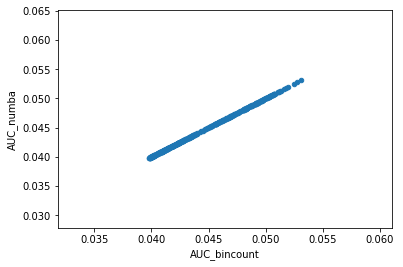

In [60]:
df.plot.scatter(x='AUC_bincount', y='AUC_numba')

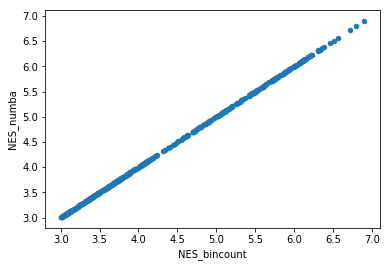

In [61]:
df.plot.scatter(x='NES_bincount', y='NES_numba')

In [62]:
df2 = impl_numba(dbs[0], modules[0]).sort_values(by=COLUMN_NAME_NES, ascending=True)
df1 = impl_bincount(dbs[0], modules[0]).sort_values(by=COLUMN_NAME_NES, ascending=True)
df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True, suffixes=('_bincount', '_numba'))

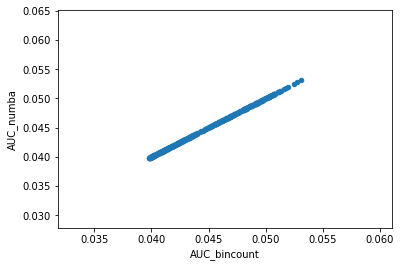

In [63]:
df.plot.scatter(x='AUC_bincount', y='AUC_numba')

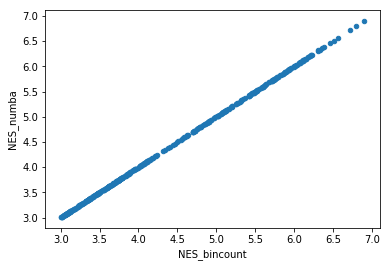

In [64]:
df.plot.scatter(x='NES_bincount', y='NES_numba')

#### 3. Compare regulomes